# Course: ICS 574
# Prject: Alchemists Project - EDA
- Date: May 1st 2024
- Project Members
    - AHMED DHAFER ALQARNI, ID: 201453160
    - WALEED ABDULLAH ALFAIFI, ID: 201640920
    - ALGHAMDI, BANDAR, ID: 202206560

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns
import numpy as np


In [4]:
# Create a Spark session
spark = SparkSession.builder.appName("Decision Tree Classifier Example 5").getOrCreate()




In [5]:
spark

In [6]:
# Load the datasets as pandas DataFrames
stocks_df = pd.read_csv("./datasets/Tadawul_stcks.csv")
brent_df = pd.read_csv("./datasets/BrentOilPrices.csv")
gold_df = pd.read_csv("./datasets/Gold_Daily.csv")

# Preprocess the stock data
stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
brent_df = brent_df[['Date', 'Brent_Price']]
gold_df = gold_df[['Date', 'Gold_Price']]
stocks_specific_df.fillna(method='ffill', inplace=True)
stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')




/var/folders/8r/wc11r95d3lgcc57lr4h_9m0w0000gn/T/ipykernel_24572/2957932426.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
/var/folders/8r/wc11r95d3lgcc57lr4h_9m0w0000gn/T/ipykernel_24572/2957932426.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
/var/folders/8r/wc11r95d3lgcc57lr4h_9m0w0000gn/T/ipykernel_24572/2957932426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [7]:
# Create a Spark DataFrame
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [8]:
# print columns of the DataFrame
stocks_brent_gold_df_spark.columns

['symbol',
 'name',
 'trading_name ',
 'Sector',
 'Date',
 'open',
 'high',
 'low',
 'Stock_Price',
 'change',
 'perc_Change',
 'volume_traded ',
 'value_traded',
 'no_trades ',
 'Brent_Price',
 'Gold_Price']

In [9]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)


24/03/31 08:58:40 WARN TaskSetManager: Stage 0 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [10]:
# index the name of the stock
indexer = StringIndexer(inputCol="name", outputCol="StockIndex")
indexed = indexer.fit(indexed).transform(indexed)

24/03/31 08:58:43 WARN TaskSetManager: Stage 3 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [11]:
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E

In [12]:
# create a feature vector by combining the features that we are going to use
vectorAssembler = VectorAssembler(inputCols=["Stock_Price", "volume_traded ", "value_traded", "no_trades ", "Brent_Price", "Gold_Price"], outputCol="features")

In [13]:
assembledData = vectorAssembler.transform(indexed)

In [14]:
# Create a VectorAssembler for the features
stocks_brent_gold_df_spark = assembledData

In [15]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+--------------------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|            features|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+--------------------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|[34.9,436609.0,1....|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00

In [16]:
# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

In [17]:
# define the evaluator
# note the metricName parameter is rmse, which stands for Root Mean Squared Error. This is the default metric for regression problems.
# Other metrics include r2 (R squared) and mae (Mean Absolute Error)
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")

In [18]:
# Define the grid of hyperparameters
# We will use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for dt.maxDepth and 5 values for dt.maxBins, this grid will have 3 x 5 = 15 parameter settings for CrossValidator to choose from.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7, 8, 9, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .build()

In [19]:
# Define the CrossValidator
# We will use a CrossValidator to select the best model.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [20]:
# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

24/03/31 08:59:10 WARN TaskSetManager: Stage 8 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:11 WARN TaskSetManager: Stage 10 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:11 WARN TaskSetManager: Stage 11 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:11 WARN TaskSetManager: Stage 13 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:12 WARN TaskSetManager: Stage 15 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:12 WARN TaskSetManager: Stage 17 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 08:59:12 WARN TaskSetManager: Stage 18 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/3

In [21]:
# get the average cross-validated RMSE
# note the RMSE is the root of the average of the squares of the differences between the predicted and the actual values
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator

# the higher the RMSE, the worse the model
# the lower the RMSE, the better the model
# the RMSE is a measure of the quality of the model
# the RMSE is scale-dependent
# the RMSE can be used to compare different models
# the RMSE can be used to compare different transformations of the same model
# the RMSE can be used to compare different models on different datasets
# the RMSE can be used to compare different models on the same dataset
# the RMSE can be used to compare different models on the same dataset with different target variables
# the RMSE can be used to compare different models on the same dataset with the same target variable
# the RMSE can be used to compare different models on the same dataset with the same target variable and different features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and different hyperparameters
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and the same hyperparameters
# the RMSE value of 0 means the model is perfect
# the RMSE value of 9 means the model is good?
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

Average RMSE:  9.57147096925156


In [22]:
# print all the parameters of the best model
print(cvModel.bestModel.extractParamMap())


{Param(parent='DecisionTreeRegressor_38721097e360', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_38721097e360', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_38721097e360', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_38721097e360', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Para

In [23]:
# print the RMSE of all the models
for rmse in cvModel.avgMetrics:
    print(rmse)
    

10.519389979879922
10.52316816202223
10.519313566125591
10.51270010992715
10.51449541655785
10.095278845548833
10.109782520942442
10.072935507958935
10.064818768716943
10.063435097226769
9.882495615806578
9.905237352913437
9.825988426875437
9.816409993737306
9.806508323128838
9.707887073076822
9.721204977859497
9.628382124244318
9.61631658114209
9.595430665787672
9.560099811199501
9.549115773516228
9.470487054022058
9.451514355036323
9.454576823620783
9.44383460355988
9.405277534194587
9.31919974705778
9.313313737066649
9.31105666825789
9.31126184754398
9.25311269425679
9.170086885424032
9.152870308064665
9.166118878677405
9.189776712774611
9.094694579299249
9.009059090285186
8.991059942003444
9.012853360618564
9.07785038467668
8.938986351992126
8.867070527198438
8.837547119611125
8.864189716883592


In [15]:
"""

an RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.

Whether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.

It's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.

Considering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:

Stock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might be considered reasonable. However, for lower-priced stocks or if you aim for high precision, this RMSE could be considered high.
Brent Oil Prices: The price range for Brent oil can vary significantly depending on market conditions. If the range is broad, an RMSE of 9.84 might be acceptable. However, for more stable periods with narrower price ranges, this value might be too high.
Ethereum Prices: Given the volatility and wide range of cryptocurrency prices, an RMSE of 9.84 could be considered reasonable, but this depends on the specific price range during your prediction period.
Gold Prices: Similar to Brent oil, the evaluation of the RMSE for gold prices depends on the price range during the period you're predicting. For a wide range, an RMSE of 9.84 might be acceptable, but for a narrower range, it could be considered high.
Overall, the acceptability of an RMSE of 9.84 in your project depends on the specific price ranges and volatility of the assets you're predicting. It's also important to compare this value to other models or benchmarks to evaluate its relative performance.


"""

"\n\nan RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.\n\nWhether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.\n\nIt's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.\n\nConsidering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:\n\nStock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might 

In [24]:
# print the feature importances

# The feature importances represent the importance of each feature in the decision tree model.

# The feature importances are calculated based on the information gain provided by each feature in splitting the data.

# The higher the feature importance, the more important the feature is in making predictions.



# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(stocks_brent_gold_df_spark.columns[2:], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)



         Feature  Importance
0  trading_name     0.448394
5            low    0.280226
3           open    0.104508
4           high    0.085006
1         Sector    0.064018
2           Date    0.017849


In [25]:
# print the feature importances
# Feature importances describe the relative importance of each feature in making accurate predictions.
# The higher the value, the more important the feature is.
# Feature importances can help you understand which features are most influential in your model's predictions.
# Feature importances can guide feature selection and model interpretation.

# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a pandas DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(["Stock_Price", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])

# display the feature importances
print(feature_importances_df)

       Feature  Importance
0  Stock_Price    0.448394
1  Brent_Price    0.064018
2   Gold_Price    0.017849


In [26]:
# print the hyperparameters of the best model
# The hyperparameters of the best model can provide insights into the configuration that yielded the best performance.
# Understanding the hyperparameters can help you tune future models and optimize their performance.
# The hyperparameters of the best model can guide further experimentation and refinement of the model.
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())

10
80


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2020-01-23 00:00:00|       90.9| 6.436046511627907|
|2020-01-22 00:00:00|       91.8|12.460087082728592|
|2020-01-21 00:00:00|       92.0|12.460087082728592|
|2020-01-20 00:00:00|       92.9|12.460087082728592|
|2020-01-16 00:00:00|       92.8|12.460087082728592|
|2020-01-15 00:00:00|       92.4|12.460087082728592|
|2020-01-14 00:00:00|       93.2| 6.436046511627907|
|2020-01-13 00:00:00|       92.7| 6.436046511627907|
|2020-01-09 00:00:00|       92.0| 6.436046511627907|
|2020-01-08 00:00:00|       90.5| 6.436046511627907|
|2020-01-07 00:00:00|       91.0| 6.436046511627907|
|2020-01-06 00:00:00|       91.9| 6.436046511627907|
|2020-01-02 00:00:00|       93.4| 6.436046511627907|
|2020-01-01 00:00:00|       93.1| 6.436046511627907|
|2019-12-31 00:00:00|       93.9| 6.436046511627907|
|2019-12-30 00:00:00|       93.7|             

24/03/31 09:10:09 WARN TaskSetManager: Stage 4105 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/03/31 09:10:10 WARN TaskSetManager: Stage 4106 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


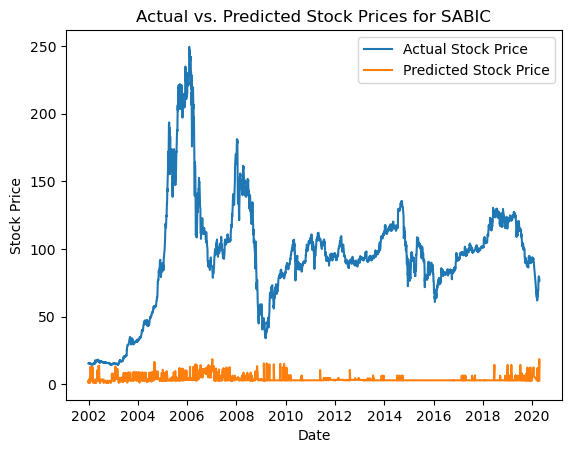

In [35]:
# create a table for SABIC actual and predicted stock prices

# get the predictions
predictions = cvModel.transform(stocks_brent_gold_df_spark)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show()

# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [1]:

""" EXPERIMENTAL """

# use the ARIMA model to predict the stock prices of SABIC
# The ARIMA model is a time series forecasting model that can be used to predict future values based on past data.
# By fitting an ARIMA model to historical stock prices, you can generate forecasts for future stock prices.
# The ARIMA model is particularly useful for capturing trends and seasonality in time series data.
# To use the ARIMA model, you need to install the statsmodels library and import the ARIMA class.
# You can then fit an ARIMA model to the historical stock prices and generate forecasts for future prices.
# Compare the ARIMA predictions with the Decision Tree predictions to evaluate the performance of both models.

# install the statsmodels library

# import the ARIMA class from the statsmodels library
from statsmodels.tsa.arima.model import ARIMA

# create a table for SABIC actual and ARIMA predicted stock prices
# get the historical stock prices for SABIC
sabic_prices = sabic_predictions.select("Date", "Stock_Price").toPandas()

# set the Date column as the index
sabic_prices.set_index("Date", inplace=True)

# fit an ARIMA model to the historical stock prices
# the order parameter specifies the (p, d, q) values for the ARIMA model
# in this example, we use an ARIMA(1, 1, 1) model
# you can experiment with different order values to improve the model
arima_model = ARIMA(sabic_prices, order=(1, 1, 1)).fit()

# generate forecasts for future stock prices using the ARIMA model
# the start and end parameters specify the range of dates for the forecasts
# in this example, we generate forecasts for the next 10 days
arima_forecasts = arima_model.forecast(steps=10)

# create a DataFrame to store the ARIMA forecasts
arima_forecasts_df = pd.DataFrame(arima_forecasts, columns=["ARIMA_Predictions"])

# add the Date column to the DataFrame
arima_forecasts_df["Date"] = pd.date_range(start=sabic_prices.index[-1], periods=10, freq="D")

# display the ARIMA forecasts
print(arima_forecasts_df)

# plot the actual and ARIMA predicted stock prices for SABIC
sns.lineplot(data=sabic_prices, x=sabic_prices.index, y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=arima_forecasts_df, x="Date", y="ARIMA_Predictions", label="ARIMA Predicted Stock Price")
plt.title("Actual vs. ARIMA Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# compare the performance of the Decision Tree and ARIMA models
# The RMSE values of the Decision Tree and ARIMA models can be compared to evaluate their performance.
# Lower RMSE values indicate more accurate predictions, while higher RMSE values suggest less accurate predictions.
# By comparing the RMSE values of the two models, you can determine which model performs better on the stock price data.
# You can also consider other metrics, such as the Mean Absolute Error (MAE) or R-squared, to assess model performance.

# calculate the RMSE of the ARIMA model
# the ARIMA forecasts are stored in the arima_forecasts DataFrame
# the actual stock prices are stored in the sabic_prices DataFrame
# calculate the squared differences between the actual and predicted values
squared_errors_arima = (arima_forecasts_df["ARIMA_Predictions"] - sabic_prices["Stock_Price"].iloc[-1:])**2

# calculate the mean squared error
mse_arima = squared_errors_arima.mean()

# calculate the root mean squared error
rmse_arima = np.sqrt(mse_arima)

# print the RMSE of the ARIMA model
print("ARIMA RMSE:", rmse_arima)

# compare the RMSE values of the Decision Tree and ARIMA models
# the Decision Tree RMSE is stored in the avg_rmse variable
# the ARIMA RMSE is stored in the rmse_arima variable
# lower RMSE values indicate more accurate predictions

# print the RMSE values of the Decision Tree and ARIMA models
print("Decision Tree RMSE:", avg_rmse)
print("ARIMA RMSE:", rmse_arima)

NameError: name 'sabic_predictions' is not defined

In [44]:
# Stop the Spark session
spark.stop()